# IST 718 Big Data Analytics
## Lab 1 
## Martin Alonso
## 2019-01-26

In [1]:
# Require packages.
import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process

### Data Importation and Cleaning

In [2]:
# Initial data exploration to understand what the data looks like and if we need any additional work before exploring the data. 
coaches = pd.read_csv('Coaches9.csv')

# Print dimension, data type, and first five rows of the data set to understand what we're working with. 
print(coaches.shape)
print(coaches.info())
print(coaches.iloc[0:6])

(129, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
School          129 non-null object
Conference      129 non-null object
Coach           129 non-null object
SchoolPay       129 non-null object
TotalPay        129 non-null object
Bonus           129 non-null object
BonusPaid       129 non-null object
AssistantPay    129 non-null object
Buyout          129 non-null object
dtypes: object(9)
memory usage: 9.1+ KB
None
                  School Conference              Coach    SchoolPay  \
0              Air Force   Mt. West       Troy Calhoun       885000   
1                  Akron        MAC       Terry Bowden    $411,000    
2                Alabama        SEC         Nick Saban  $8,307,000    
3  Alabama at Birmingham      C-USA         Bill Clark    $900,000    
4      Appalachian State   Sun Belt  Scott Satterfield    $712,500    
5                Arizona     Pac-12       Kevin Sumlin  $1,600,000    

      TotalPay      

From our first analysis of the data, we can see that we are dealing with 9 variables and 129 observations. All variables are classified as objects however, when looking at the data, we can see that most of the numerical data have a dollar sign in front of them. Also, there are missing data like bonuses paid and buyouts.  
Furthermore, it would be ideal if we had a historical record of wins and losses for each coach, each school's graduation date, and stadium size. Additional data such as points scored and points allowed plus games played can also help us determine which teams are more prone to be offense-oriented teams and which ones defense oriented. 

In [3]:
# Check one conference to see how the data is distributed and if there are any variables that need cleaning. 
coaches[coaches['Conference']=='ACC']

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
14,Boston College,ACC,Steve Addazio,"$2,514,859","$2,514,859",--,--,$0,--
23,Clemson,ACC,Dabo Swinney,"$6,205,000","$6,543,350","$1,125,000","$500,000",$0,"$35,000,000"
28,Duke,ACC,David Cutcliffe,"$2,540,928","$2,540,928",--,--,$0,--
34,Florida State,ACC,Willie Taggart,"$5,000,000","$5,000,000","$1,475,000",--,$0,"$21,958,333"
39,Georgia Tech,ACC,Paul Johnson,"$3,060,018","$3,060,018","$1,330,000","$225,000",$0,"$4,000,000"
54,Louisville,ACC,Bobby Petrino,"$3,980,434","$3,980,434","$1,472,917","$869,917",$0,"$14,056,250"
60,Miami (Fla.),ACC,Mark Richt,"$4,058,061","$4,058,061",--,--,$0,--
75,North Carolina,ACC,Larry Fedora,"$2,575,000","$2,575,000","$900,000","$50,000",$0,"$12,215,625"
76,North Carolina State,ACC,Dave Doeren,"$3,000,000","$3,000,000","$1,350,000","$275,000",$0,"$6,125,000"
89,Pittsburgh,ACC,Pat Narduzzi,"$3,017,718","$3,017,718",--,--,$0,--


Time to clean the data. We'll remove the dollar sign and commas from SchoolPay, TotalPay, Bonus, BonusPaid, AssistantPay, and Buyout. Then, we'll replace -- values with zeroes. 

In [4]:
# Selects all columns that should be numeric.
numColumns = ['SchoolPay', 'TotalPay', 'Bonus', 'BonusPaid', 'AssistantPay', 'Buyout']

# Replaces dollar signs, commas, and hyphens to convert numColumns variables into floats. 
for i in numColumns:
    coaches[i] = coaches[i].replace('[$,]', '', regex=True)
    coaches[i] = coaches[i].replace('[--]', '0', regex=True)
    coaches[i] = coaches[i].astype(float)
     
coaches.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0


Now that the initial data has been cleaned, it is time to import the additional files that have been downloaded and add them to the original data. The files that will be imported have data on each college's rank, record, graduation rate, and stadium capacity.   
Since the data was not cleaned prior to importation, we'll load each comma-separated value file one-by-one. After importing, it will be cleaned and then merged into a single data frame. 

In [5]:
# Load new data sets. 
rank = pd.read_csv('CollegeRank.csv')
records = pd.read_csv('CollegeRecords.csv')
graduation_rate = pd.read_csv('GraduationRates.csv')
stadiums = pd.read_csv('Stadiums.csv')

We'll work on each data set individually. 

In [6]:
# Print initial features of records to understand the data frome. 
print(records.shape)
print(records.info())
print(records.iloc[0:6])

(130, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 8 columns):
Conference    130 non-null object
School        130 non-null object
HomeW         130 non-null int64
HomeL         130 non-null int64
ConfW         130 non-null int64
ConfL         130 non-null int64
PF            130 non-null int64
PA            130 non-null int64
dtypes: int64(6), object(2)
memory usage: 8.2+ KB
None
                  Conference                School  HomeW  HomeL  ConfW  \
0  Atlantic Coast Conference               Clemson      8      0     15   
1  Atlantic Coast Conference              Syracuse      6      2     10   
2  Atlantic Coast Conference  North Carolina State      5      3      9   
3  Atlantic Coast Conference        Boston College      4      4      7   
4  Atlantic Coast Conference           Wake Forest      3      5      7   
5  Atlantic Coast Conference         Florida State      3      5      5   

   ConfL   PF   PA  
0      0  664  197 

In [7]:
# Since we have a Conference variable in this data set and the initial coaches data set, we'll compare them and check if there are any observations 
# we can replace
print(len(coaches.Conference.unique()), coaches.Conference.unique())
print(len(records.Conference.unique()), records.Conference.unique())

origName = ['Atlantic Coast Conference', 'American Athletic Conference', 'Big 12', 'Big 10', 'Conference USA', 'Independents', 'Mid-American Conference',
           'Mountain West', 'Pac-12', 'Southeastern Conference', 'Sun Belt']
newName = ['ACC', 'AAC', 'Big 12', 'Big Ten', 'C-USA', 'Ind.', 'MAC', 'Mt. West', 'Pac-12', 'SEC', 'Sun Belt']

# Both data sets have 11 conferences. So far so good. We'll convert the records conferences to the same format as the coaches conferences. 
records['Conference'] = records['Conference'].replace(origName, newName, regex=False)
records.head()

# Conferences were successfully updated. 

11 ['Mt. West' 'MAC' 'SEC' 'C-USA' 'Sun Belt' 'Pac-12' 'Ind.' 'Big 12' 'ACC'
 'AAC' 'Big Ten']
11 ['Atlantic Coast Conference' 'American Athletic Conference' 'Big 12'
 'Big 10' 'Conference USA' 'Independents' 'Mid-American Conference'
 'Mountain West' 'Pac-12' 'Southeastern Conference' 'Sun Belt']


,Conference,School,HomeW,HomeL,ConfW,ConfL,PF,PA
0,ACC,Clemson,8,0,15,0,664,197
1,ACC,Syracuse,6,2,10,3,523,351
2,ACC,North Carolina State,5,3,9,4,440,324
3,ACC,Boston College,4,4,7,5,384,308
4,ACC,Wake Forest,3,5,7,6,427,433


The same process will be repeated for the remaining tables before we do some fuzzy matching. 

In [8]:
# Cleaning Graduation Rate data set. 
print(len(graduation_rate.Conference.unique()), print(graduation_rate.Conference.unique()))

# Rename Conferences.
grOrgName = ['Southland Conference', 'Mid-American Conference', 'Southwestern Athletic Conf.', 'Southeastern Conference', 'Conference USA',
             'Colonial Athletic Association', 'Sun Belt Conference', 'Pac-12 Conference', 'Ohio Valley Conference', 'Big South Conference',
             'Big 12 Conference', 'Mid-Eastern Athletic Conf.', 'Mountain West Conference', 'Atlantic Coast Conference', 'Independent', 
             'The Ivy League', 'Northeast Conference', 'Patriot League', 'Pioneer Football League', 'Big Sky Conference', 
             'American Athletic Conference', 'Southern Conference', 'Missouri Valley Football Conference', 'Big Ten Conference']

# I don't know all the original names so, for those names that are not in the original dataset, I'll invent new ones. 
grNewName = ['SLC', 'MAC', 'SWA', 'SEC', 'C-USA', 'CAA', 'Sun Belt', 'Pac-12', 'OV', 'Big South', 'Big 12', 'MEAC', 'Mt. West', 'ACC', 'Ind.', 
            'Ivy', 'NEC', 'PL', 'PFL', 'Big Sky', 'AAC', 'SC', 'MVFC', 'Big Ten']

graduation_rate['Conference'] = graduation_rate['Conference'].replace(grOrgName, grNewName, regex=False)

# We'll also drop the final two columns as they appear to be noise. 
graduation_rate = graduation_rate.iloc[:, 0:8]

# Check final result to see that everything is correct. 
graduation_rate.head()

['Southland Conference' 'Mid-American Conference'
 'Southwestern Athletic Conf.' 'Southeastern Conference' 'Conference USA'
 'Colonial Athletic Association' 'Sun Belt Conference' 'Pac-12 Conference'
 'Ohio Valley Conference' 'Big South Conference' 'Big 12 Conference'
 'Mid-Eastern Athletic Conf.' 'Mountain West Conference'
 'Atlantic Coast Conference' 'Independent' 'The Ivy League'
 'Northeast Conference' 'Patriot League' 'Pioneer Football League'
 'Big Sky Conference' 'American Athletic Conference' 'Southern Conference'
 'Missouri Valley Football Conference' 'Big Ten Conference']
24 None


,Cohort Year,Year,School,Conference,Sport,State,GSR,FGR
0,2011,2017-2018,Abilene Christian University,SLC,Football,TX,61,41.0
1,2011,2017-2018,University of Akron,MAC,Football,OH,72,61.0
2,2011,2017-2018,Alabama A&M University,SWA,Football,AL,62,47.0
3,2011,2017-2018,Alabama State University,SWA,Football,AL,58,42.0
4,2011,2017-2018,University of Alabama,SEC,Football,AL,84,63.0


In [9]:
# The stadium data set appears to already be clean. However, the Capacity variable is stored as an object rather than as numeric.
print(stadiums.info())

# Remove commas from Capacity variable and convert to numeric
stadiums['Capacity'] = stadiums['Capacity'].replace(',', '', regex=True).astype(float)
stadiums.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 5 columns):
Stadium       128 non-null object
College       128 non-null object
Conference    128 non-null object
Capacity      128 non-null object
Opened        128 non-null int64
dtypes: int64(1), object(4)
memory usage: 5.1+ KB
None


,Stadium,College,Conference,Capacity,Opened
0,Bright House Networks Stadium,Central Florida,AAC,45323.0,2007
1,Nippert Stadium,Cincinnati,AAC,40000.0,1916
2,Dowdy Ficklen Stadium,East Carolina,AAC,50000.0,1963
3,TDECU Stadium,Houston,AAC,40000.0,2014
4,Liberty Bowl,Memphis,AAC,62380.0,1965


The rank data set is already cleaned however, it doesn't have a Conference variable, only a School variable which means it will be very hard to match each school's rank to their actual school. Nevertheless, we do have each school's win-loss record, so we might be able to use that when matching schools.  
We'll now proceed to merging the data sets using a combination of pandas and fuzzy matching. 

In [10]:
# In records, replace UCF with Central Florida, Miami (FL) with Miami (Fla.), and UTSA, UTEP, and Southern Miss with Texas-San Antonio, 
# Texas-El Paso, and Southern Mississippi
records['School'] = records['School'].replace('UCF', 'Central Florida', regex=False)
records['School'] = records['School'].replace('Miami (FL)', 'Miami (Fla.)', regex=False)
records['School'] = records['School'].replace(['UTSA', 'UTEP', 'Southern Miss'], ['Texas-San Antonio', 'Texas-El Paso', 'Southern Mississippi'], regex=False)

In [11]:
# Build the fuzzy matcher
records['SchoolFuzz'] = records.School.apply(lambda x: [process.extract(x, coaches.School, limit=1)][0][0][0])
coaches['SchoolFuzz'] = coaches.School.apply(lambda x: [process.extract(x, records.School, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['Conference', 'SchoolFuzz']
right_on = ['Conference', 'SchoolFuzz']

# Merge the two data frames.
df_coach_record = pd.merge(coaches, records, how='left', left_on=left_on, right_on=right_on)
df_coach_record[df_coach_record.HomeW.isnull()]

# There are five schools that weren't able to be matched. I'll manually change these and match them once more. 

,School_x,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,SchoolFuzz,School_y,HomeW,HomeL,ConfW,ConfL,PF,PA


The merge done to cells prior will be rerun. Since all the schools have matched completely, there are no null records. 

In [12]:
# Drop columns and rename School_x variable to recreate fuzzy matching with next data frame. 
df_coach_record.drop(['SchoolFuzz', 'School_y'], axis=1, inplace=True)
df_coach_record.rename(columns={'School_x':'School'}, inplace=True)

The process will be repeated for the remaining data sets. 

In [13]:
# Additional cleaning needed to be done in order to get a full match with fuzzywuzzy. 
# Original names in df_coach_record data set.
oldSchool = ['Connecticut', 'Georgia Tech', 'Miami (Fla.)', 'Virginia', 'Virginia Tech', 'Kansas', 'Kansas State', 'Texas', 
            'Illinois', 'Indiana', 'Iowa', 'Michigan', 'Northwestern', 'Penn State', 'Rutgers', 'Texas-San Antonio', 
            'Fresno State', 'New Mexico', 'California', 'Colorado', 'UCLA', 'Utah', 'Washington', 'Alabama', 'Arkansas', 'Florida', 
            'Georgia', 'Kentucky', 'LSU', 'South Carolina', 'Tennessee', 'Louisiana-Monroe']

# School names as they appear on graduation_rate data set. 
newSchool = ['University of Connecticut', 'Georgia Institute of Technology', 'University of Miami (Florida)', 'University of Virginia', 
            'Virginia Polytechnic Institute and State University', 'University of Kansas', 'Kansas State University', 
            'University of Texas at Austin', 'University of Illinois Urbana-Champaign', 'Indiana University, Bloomington', 
            'University of Iowa', 'University of Michigan', 'Northwestern University', 'Pennsylvania State University', 
            'Rutgers, The State University of New Jersey, New Brunswick', 'University of Texas at San Antonio', 
            'California State University, Fresno', 'University of New Mexico', 'University of California, Berkeley', 
            'University of Colorado, Boulder', 'University of California, Los Angeles', 'University of Utah', 'University of Washington', 
            'University of Alabama', 'University of Arkansas, Fayetteville', 'University of Florida', 'University of Georgia', 
            'University of Kentucky', 'Louisiana State University', 'University of South Carolina, Columbia', 
            'University of Tennessee, Knoxville', 'University of Louisiana at Monroe']

# Replaces old names with new names so data sets match one-on-one
df_coach_record['School'] = df_coach_record['School'].replace(oldSchool, newSchool, regex=False)

In [17]:
graduation_rate.head()

# Build the fuzzy matcher
df_coach_record['SchoolFuzz'] = df_coach_record.School.apply(lambda x: [process.extract(x, graduation_rate.School, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['Conference', 'SchoolFuzz']
right_on = ['Conference', 'School']


# Merge the two data frames.
df_coach_record_gr = pd.merge(df_coach_record, graduation_rate, how='left', left_on=left_on, right_on=right_on)
df_coach_record_gr.head()

,School_x,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,PF,PA,SchoolFuzz,Cohort Year,Year,School_y,Sport,State,GSR,FGR
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,3,...,363,309,U.S. Air Force Academy,2011,2017-2018,U.S. Air Force Academy,Football,CO,77,NaN
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2,...,227,326,University of Akron,2011,2017-2018,University of Akron,Football,OH,72,61.0
2,University of Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,8,...,684,271,University of Alabama,2011,2017-2018,University of Alabama,Football,AL,84,63.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,7,...,418,238,University of Alabama at Birmingham,2011,2017-2018,University of Alabama at Birmingham,Football,AL,71,58.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,7,...,485,201,Appalachian State University,2011,2017-2018,Appalachian State University,Football,NC,71,67.0


In [18]:
# Drop columns duplicated to keep data set as small as possible.
df_coach_record_gr.drop(['SchoolFuzz', 'School_y'], axis=1, inplace=True)
df_coach_record_gr.rename(columns={'School_x':'School'}, inplace=True)

In [19]:
# Stadium matching
df_coach_record_gr['SchoolFuzz'] = df_coach_record_gr.School.apply(lambda x: [process.extract(x, stadiums.College, limit=1)][0][0][0])

# Matchers
left_on = ['Conference', 'SchoolFuzz']
right_on = ['Conference', 'College']

# Fuzzy join
df_coach_record_gr_stad = pd.merge(df_coach_record_gr, stadiums, how='left', left_on=left_on, right_on=right_on)
df_coach_record_gr_stad.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,Year,Sport,State,GSR,FGR,SchoolFuzz,Stadium,College,Capacity,Opened
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,3,...,2017-2018,Football,CO,77,NaN,Air Force,Falcon Stadium,Air Force,52237.0,1962.0
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2,...,2017-2018,Football,OH,72,61.0,Akron,InfoCision Stadium,Akron,30000.0,2009.0
2,University of Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,8,...,2017-2018,Football,AL,84,63.0,University of Alabama,Bryant Denny Stadium,University of Alabama,101821.0,1929.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,7,...,2017-2018,Football,AL,71,58.0,University of Texas at San Antonio,Alamodome,University of Texas at San Antonio,65000.0,1993.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,7,...,2017-2018,Football,NC,71,67.0,Appalachain State,Kidd Brewer Stadium,Appalachain State,24150.0,1962.0


In [20]:
df_coach_record_gr_stad[df_coach_record_gr_stad.Stadium.isnull()]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,Year,Sport,State,GSR,FGR,SchoolFuzz,Stadium,College,Capacity,Opened
24,Coastal Carolina,Sun Belt,Joe Moglia,400000.0,400000.0,800000.0,25000.0,0.0,516667.0,2,...,2017-2018,Football,SC,73,58.0,"University of South Carolina, Columbia",NaN,NaN,NaN,NaN
50,Liberty,Ind.,Turner Gill,947281.0,947281.0,0.0,0.0,0.0,0.0,0,...,2017-2018,Football,VA,71,66.0,University of Connecticut,NaN,NaN,NaN,NaN


There are only two schools, Coastal Carolina and Liberty, who do not have any stadium information within the stadiums data set. Later on, when we do exploratory data analysis, we'll decide on the best way to fill these missing values.
In the meantime, let's move on to the final dataset and add rank to those teams that feature in the rank dataset. 

In [21]:
# Add college rank
df_final = pd.merge(df_coach_record_gr_stad, rank, how='left', left_on='School', right_on='SCHOOL')
df_final.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,SchoolFuzz,Stadium,College,Capacity,Opened,RANK,SCHOOL,W,L,PREVIOUS RANK
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,3,...,Air Force,Falcon Stadium,Air Force,52237.0,1962.0,NaN,NaN,NaN,NaN,NaN
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2,...,Akron,InfoCision Stadium,Akron,30000.0,2009.0,NaN,NaN,NaN,NaN,NaN
2,University of Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,8,...,University of Alabama,Bryant Denny Stadium,University of Alabama,101821.0,1929.0,1.0,University of Alabama,13.0,0.0,1.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,7,...,University of Texas at San Antonio,Alamodome,University of Texas at San Antonio,65000.0,1993.0,NaN,NaN,NaN,NaN,NaN
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,7,...,Appalachain State,Kidd Brewer Stadium,Appalachain State,24150.0,1962.0,NaN,NaN,NaN,NaN,NaN


In [22]:
len(df_final[df_final['RANK'].isnull()])

112

Though there are 129 observations in the data set, it appears that we've only managed to merge 17 of the ranked colleges.  
We'll now proceed to clean the final dataset once more and begin doing some exploratory data analysis.

In [23]:
# We'll drop the Sport, SchoolFuzz, College, SCHOOL, W, L columns as they are redundant. 
df_final.drop(['Sport', 'SchoolFuzz', 'College', 'SCHOOL', 'W', 'L'], axis=1, inplace=True)

# After that, we'll replace NaN values with zero.
df_final['RANK'] = df_final['RANK'].fillna(0)
df_final['PREVIOUS RANK'] = df_final['PREVIOUS RANK'].fillna(0)

# Additionally, we can create the following variables to help us with our study: AwayW, AwayL, HomeRecord, AwayRecord, OverallRecord, RankDiff, 
# OffensiveRating, DefensiveRating, PointsScoredPG, PointsAllowedPG
df_final['AwayW'] = df_final['ConfW'] - df_final['HomeW'] # Wins as visitor
df_final['AwayL'] = df_final['ConfL'] - df_final['HomeL'] # Losses as visitor
df_final['HomeRecord'] = df_final['HomeW']/(df_final['HomeW']+df_final['HomeL']) # Winning record at home
df_final['AwayRecord'] = df_final['AwayW']/(df_final['AwayW']+df_final['AwayL']) # Winning record as visitor
df_final['ConfRecord'] = df_final['ConfW']/(df_final['ConfW']+df_final['ConfL']) # Overall winning record
df_final['RankDiff'] = df_final['RANK'] - df_final['PREVIOUS RANK'] # Change in rank 
df_final['AvgPS'] = df_final.groupby('Conference')['PF'].transform('mean') # Average Points Scored by Conference
df_final['AvgPA'] = df_final.groupby('Conference')['PA'].transform('mean') # Average Points Allowed by Conference
df_final['OffRat'] = (df_final['PF'] - df_final['AvgPA'])/df_final['AvgPS'] # Offensive rating for each team
df_final['DefRat'] = (df_final['PA'] - df_final['AvgPS'])/df_final['AvgPA'] # Defensive rating for each team
df_final['PPG'] = df_final['PF']/(df_final['ConfW']+df_final['ConfL']) # Points Scored per Game
df_final['PAG'] = df_final['PA']/(df_final['ConfW']+df_final['ConfL']) # Points Allowed per Game


In [24]:
df_final.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,HomeRecord,AwayRecord,ConfRecord,RankDiff,AvgPS,AvgPA,OffRat,DefRat,PPG,PAG
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,3,...,0.375,0.500000,0.416667,0.0,377.416667,345.000000,0.047693,-0.198309,30.250000,25.750000
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2,...,0.250,0.500000,0.333333,0.0,364.666667,368.000000,-0.386654,-0.105072,18.916667,27.166667
2,University of Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,8,...,1.000,0.857143,0.933333,0.0,418.142857,304.857143,0.906730,-0.482662,45.600000,18.066667
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,7,...,0.875,0.666667,0.785714,0.0,326.428571,339.642857,0.240044,-0.260358,29.857143,17.000000
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,7,...,0.875,0.800000,0.846154,0.0,357.400000,360.400000,0.348629,-0.433962,37.307692,15.461538


### Exploratory Data Analysis

We'll begin by using pandas' describe function to check the distribution of the data. For variables of type string or object, we'll check how many unique variables there are in order to gain a better perspective of the data. 

In [25]:
df_final.describe()

,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,HomeL,ConfW,ConfL,...,HomeRecord,AwayRecord,ConfRecord,RankDiff,AvgPS,AvgPA,OffRat,DefRat,PPG,PAG
count,1.300000e+02,1.300000e+02,1.300000e+02,1.300000e+02,130.0,1.300000e+02,130.000000,130.000000,130.000000,130.000000,...,124.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,2.329275e+06,2.335775e+06,7.195159e+05,1.012164e+05,0.0,6.682650e+06,3.961538,3.946154,6.800000,5.961538,...,0.500672,0.577037,0.523685,0.000000,378.253846,349.507692,0.071165,-0.088066,29.445119,27.604153
std,1.892639e+06,1.897100e+06,6.657034e+05,2.082616e+05,0.0,9.980033e+06,2.280364,2.269827,3.086354,2.540841,...,0.258972,0.257513,0.218819,0.482243,28.194818,25.745109,0.274145,0.252246,6.902180,7.154506
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.083333,-4.000000,326.428571,304.857143,-0.519694,-0.810684,13.500000,13.133333
25%,7.719275e+05,7.719275e+05,2.125000e+05,0.000000e+00,0.0,5.180752e+05,2.000000,2.000000,5.000000,4.000000,...,0.250000,0.350000,0.416667,0.000000,360.833333,330.750000,-0.140328,-0.261647,24.395833,22.173077
50%,1.775000e+06,1.815000e+06,6.050000e+05,2.000000e+04,0.0,2.590104e+06,4.000000,4.000000,7.000000,6.000000,...,0.500000,0.600000,0.538462,0.000000,377.416667,345.000000,0.090561,-0.090199,29.461538,26.961538
75%,3.550000e+06,3.550000e+06,1.018750e+06,9.875000e+04,0.0,8.791667e+06,6.000000,6.000000,9.000000,7.000000,...,0.666667,0.800000,0.692308,0.000000,396.357143,368.000000,0.231206,0.084576,33.524038,32.450321
max,8.307000e+06,8.307000e+06,3.100000e+06,1.350000e+06,0.0,6.812500e+07,8.000000,9.000000,15.000000,11.000000,...,1.000000,1.000000,1.000000,3.000000,426.500000,403.750000,0.906730,0.565886,48.357143,50.416667


A few things immediately pop up. We can see that there are 130 observations in total. For the first four columns, it is weird that we have a minimum of zero. We will have to make sure that we don't have missing variables or whether this is the variable we will be trying to predict: the salary of the Syracuse coach.  
It is surprising, as well that no assistant is paid, all records appear to indicate zero. Because of this, we can omit this column in our further analysis.  
Moving on the team record, it is interesting that the average home record is .500 but the average away record is .577. This might lead us to think that College Football - at least at the Division I stage - has no home field advantage. Regarding rank, no team climbed more than three places from the previous year rank, and no team dropped by more than four.  
Finally, offensive ratings tend to be much higher than defensive ratings and there is a very small difference between the average points scored per game and the average points allowed per game.  
As to the remaining columns, it is imperative that we know how many schools there are per conference.  

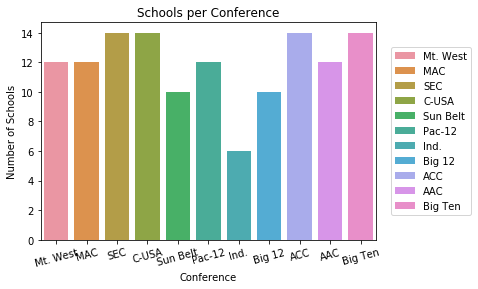

In [51]:
# Number of schools per conference. 
sns.countplot(x='Conference', data=df_final, hue='Conference', dodge=False)
_ = plt.xlabel('Conference')
_ = plt.ylabel('Number of Schools')
_ = plt.title('Schools per Conference')
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.xticks(rotation=15)
plt.show()

There are four conferences that have 14 schools, while only one - the Independent conference - has six schools. On average, there are 11.8 schools per conference. 

We want to predict how much a coach should be paid to take over a team. Our independent variable will then be the TotalPay variable. Of interest to us is how much each conference pays their coaches. We also want to know how winning affects wages, and if there's a difference between coaches that tend to win more at home than away or vice versa; and whether offense oriented teams tend to pay more than defense oriented teams.  
We also want to answer if there is a relationship between Points Per Season and Points Per Game - both scored and allowed - and Total Pay. 

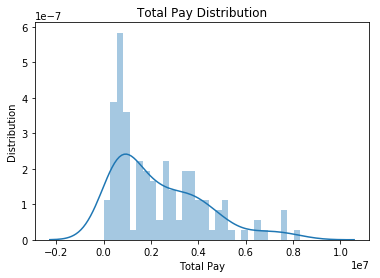

In [57]:
# Total Pay Distribution.
# We'll plot a histogram to gauge whether TotalPay follows a normal distribution or is skewed. 
sns.distplot(df_final.TotalPay, bins = 30)
_ = plt.title('Total Pay Distribution')
_ = plt.xlabel('Total Pay')
_ = plt.ylabel('Distribution')
plt.show()

The data are skewed to the left with more coaches making less than 200,000 dollars. A very high wage when compared to the average person. 
There appear to be a number of coaches whose salary has not been reported. We must find who are these coaches, and how many data points they represent, to determine whether they should be dropped from the data set. 

In [58]:
df_final[df_final['TotalPay'] == 0]

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,HomeRecord,AwayRecord,ConfRecord,RankDiff,AvgPS,AvgPA,OffRat,DefRat,PPG,PAG
12,Baylor,Big 12,Matt Rhule,0.0,0.0,0.0,0.0,0.0,0.0,4,...,0.444444,0.750000,0.538462,0.0,426.500000,368.600000,0.036108,-0.039338,29.538462,31.692308
16,Brigham Young,Ind.,Kalani Sitake,0.0,0.0,0.0,0.0,0.0,0.0,0,...,NaN,0.538462,0.538462,0.0,380.666667,366.333333,-0.032399,-0.280255,27.230769,21.384615
91,Rice,C-USA,Mike Bloomgren,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0.125000,0.200000,0.153846,0.0,326.428571,339.642857,-0.286871,0.416824,18.923077,36.000000
99,Southern Methodist,AAC,Sonny Dykes,0.0,0.0,0.0,0.0,0.0,0.0,4,...,0.500000,0.250000,0.416667,0.0,392.833333,403.750000,-0.098642,0.074716,30.416667,35.250000


Four schools show no data whatsoever as to how much they pay their coaches. Given that these data points represent three percent of our observations, we can set them aside until further notice, since they might wrongly skew our model. 

In [59]:
# If you want to make God laugh, name a data frame df_final. 
df_final2 = df_final[df_final['TotalPay'] > 0]
df_final2.shape

(126, 37)

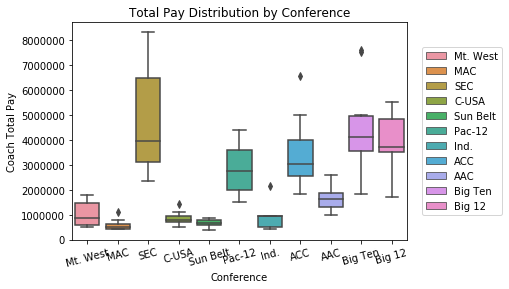

In [60]:
# Exploring the relationship between Total Pay and Conference. 
sns.boxplot(x='Conference', y='TotalPay', data=df_final2, hue='Conference', dodge=False)
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.xlabel('Conference')
_ = plt.ylabel('Coach Total Pay')
_ = plt.title('Total Pay Distribution by Conference')
_ = plt.xticks(rotation=15)
plt.show()

By far the SEC appears to have the best paying coaches. The Big Ten and Big 12 Conferences aren't far behind; while Mountain West, MAC, C-USA, Sun Belt, and Independent have the lowest paying coaches. We can assume, then, that Conference will be a driving factor in determining a coach's salary. 

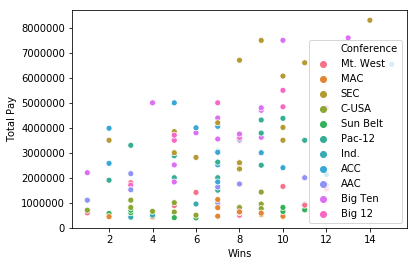

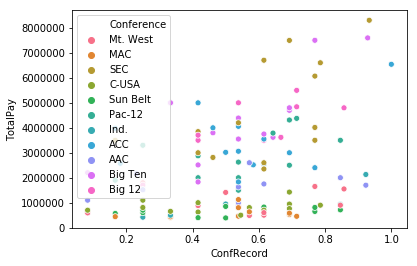

In [63]:
# Build an lm plot with loess regression. 
sns.scatterplot(x='ConfW', y='TotalPay', data=df_final2, hue='Conference')
_ = plt.xlabel('Wins')
_ = plt.ylabel('Total Pay')
plt.show()

sns.scatterplot(x='ConfRecord', y='TotalPay', data=df_final2, hue='Conference')

plt.show()

In [ ]:
# Points Scored Per Game and per Season
# Points Allowed Per Game and per Season

In [ ]:
# Offensive and Defensive Ratings vs Total Pay 

### Building the model

### Evaluating results

### Final thoughts and recommendations